In [ ]:
import requests
import pandas as pd
import plotly.express as px
import pandas as pd
from datetime import datetime

# Treasury Marketable Securities
> Data provided by [Treasury Direct](https://www.treasurydirect.gov/marketable-securities/)

## Intro 

Treasury marketable securities are debt instruments issued by the U.S. Department of the Treasury to finance the government’s operations and obligations. They are backed by the full faith and credit of the U.S. Government. 

A security is a financial tool that represents value other than cash. The most common examples are stocks and bonds. Treasury securities are like bonds in that they are debt instruments that represent money borrowed. In return, the borrower promises to pay back the money at a future date, often with interest. Think of it as lending money to someone who will pay you back later, plus a little extra. 'Marketable' means that they can be bought and sold after they are originally issued. 

For the government, treasury securities are a key tool to raise funds to cover budget deficits, pay for infrastructure, defense, social programs, and other federal expenditures. They enable the government to finance deficits, ensuring it can meet its spending commitments without needing to raise taxes or cut services. They're also a monetary policy tool. These securities in the open market to control the money supply and interest rates, thereby influencing economic activity. This is part of the Fed’s open market operations.  

For the investors that buy them, treasury securities offer a safe investment that is highly liquid, meaning it can easily be bought and sold. During periods of economic uncertainty or market volatility, investors flock to Treasuries for safety. This keeps demand high, particularly in global financial markets. The issuance and trading of Treasury securities reflect government fiscal policy and can influence market perceptions about economic health, debt sustainability, and inflation expectations.

## Data

The major types of Treasury marketable securities include:
- **Treasury Bills (T-Bills)**: Short-term securities that mature in one year or less. They are sold at a discount and do not pay interest but instead are redeemed at face value upon maturity.
- **Treasury Notes (T-Notes)**: Medium-term securities with maturities ranging from 2 to 10 years. These securities pay interest every six months.
- **Treasury Bonds (T-Bonds)**: Long-term securities with maturities of 20 to 30 years. They also pay interest every six months.
- **Treasury Inflation-Protected Securities (TIPS)**: Securities that provide protection against inflation. Their principal value adjusts based on changes in the Consumer Price Index (CPI), and they pay interest twice a year.

We'll look at the underlying data provided by the Treasury to see if we can learn more about the economy as a whole.

### Request
> A `GET` request to [treasurydirect.gov](treasurydirect.gov)

In [ ]:
def securities_search(security_type):
    url = 'http://www.treasurydirect.gov/TA_WS/securities/search'
    params = {'type':'{}'.format(security_type)}
    
    r = requests.get(url,params)
    return r.json()
    

A quick preview: 

In [ ]:
notes = securities_search('Note') # <-- returns a list of dictionaries 
pd.DataFrame(notes[:5])

,cusip,issueDate,securityType,securityTerm,maturityDate,interestRate,refCpiOnIssueDate,refCpiOnDatedDate,announcementDate,auctionDate,...,treasuryRetailTendersAccepted,type,unadjustedAccruedInterestPer1000,unadjustedPrice,updatedTimestamp,xmlFilenameAnnouncement,xmlFilenameCompetitiveResults,xmlFilenameSpecialAnnouncement,tintCusip1,tintCusip2
0,91282CLM1,2024-09-30T00:00:00,Note,7-Year,2031-09-30T00:00:00,,,,2024-09-19T00:00:00,2024-09-26T00:00:00,...,Yes,Note,,,2024-09-19T11:02:43,A_20240919_5.xml,,,912834XZ6,
1,91282CLN9,2024-09-30T00:00:00,Note,5-Year,2029-09-30T00:00:00,,,,2024-09-19T00:00:00,2024-09-25T00:00:00,...,Yes,Note,,,2024-09-19T11:40:24,A_20240919_4.xml,,,,
2,91282CLP4,2024-09-30T00:00:00,Note,2-Year,2026-09-30T00:00:00,,,,2024-09-19T00:00:00,2024-09-24T00:00:00,...,Yes,Note,,,2024-09-19T11:02:28,A_20240919_2.xml,,,,
3,91282CLF6,2024-09-16T00:00:00,Note,9-Year 11-Month,2034-08-15T00:00:00,3.875000,,,2024-09-05T00:00:00,2024-09-11T00:00:00,...,Yes,Note,,,2024-09-11T13:04:03,A_20240905_1.xml,R_20240911_2.xml,,,
4,91282CLL3,2024-09-16T00:00:00,Note,3-Year,2027-09-15T00:00:00,3.375000,,,2024-09-05T00:00:00,2024-09-10T00:00:00,...,Yes,Note,,,2024-09-10T13:03:53,A_20240905_6.xml,R_20240910_2.xml,,912834XY9,


### Data Modeling 

In [ ]:
all_data = dict(
    notes = securities_search('Note'),
    bonds = securities_search('Bond'),
    tips = securities_search('TIPS'), # inflation protected securities 
    frn = securities_search('FRN'), # floating rate notes
    bills = securities_search('Bill')
)


In [ ]:
df = pd.DataFrame(all_data['bonds'])
df['maturityDate'] = pd.to_datetime(df['maturityDate'])
df['issueDate'] = pd.to_datetime(df['issueDate'])
for c in ['interestRate','adjustedPrice','pricePer100','lowPrice','lowYield','highPrice','highYield']:
    df[c]=pd.to_numeric(df[c])

In [ ]:




# Define face value (typically 100 for bonds)
face_value = 100

# Coupon Payment calculation
df['couponPayment'] = (df['interestRate'] / 100) * face_value

# Years to maturity calculation
df['yearsToMaturity'] = (df['maturityDate'] - df['issueDate']).dt.days / 365

# Calculate Gross Yield (YTM) approximation
df['YTM'] = (df['couponPayment'] + (face_value - df['pricePer100']) / df['yearsToMaturity']) / ((face_value + df['pricePer100']) / 2)

# View the result
df[['cusip', 'issueDate', 'maturityDate', 'interestRate', 'adjustedPrice','pricePer100', 'couponPayment', 'yearsToMaturity', 'YTM']].head()

,cusip,issueDate,maturityDate,interestRate,adjustedPrice,pricePer100,couponPayment,yearsToMaturity,YTM
0,912810UD8,2024-09-30,2044-08-15,4.125,NaN,101.159820,4.125,19.887671,0.040432
1,912810UC0,2024-09-16,2054-08-15,4.250,NaN,104.064869,4.250,29.931507,0.040322
2,912810UD8,2024-09-03,2044-08-15,4.125,NaN,99.524806,4.125,19.961644,0.041587
3,912810UC0,2024-08-15,2054-08-15,4.250,NaN,98.928757,4.250,30.019178,0.043088
4,912810UB2,2024-07-31,2044-05-15,4.625,NaN,102.062500,4.625,19.802740,0.044747


In [ ]:
df['pricePer100'].corr(df['YTM'])

-0.049642087831047434

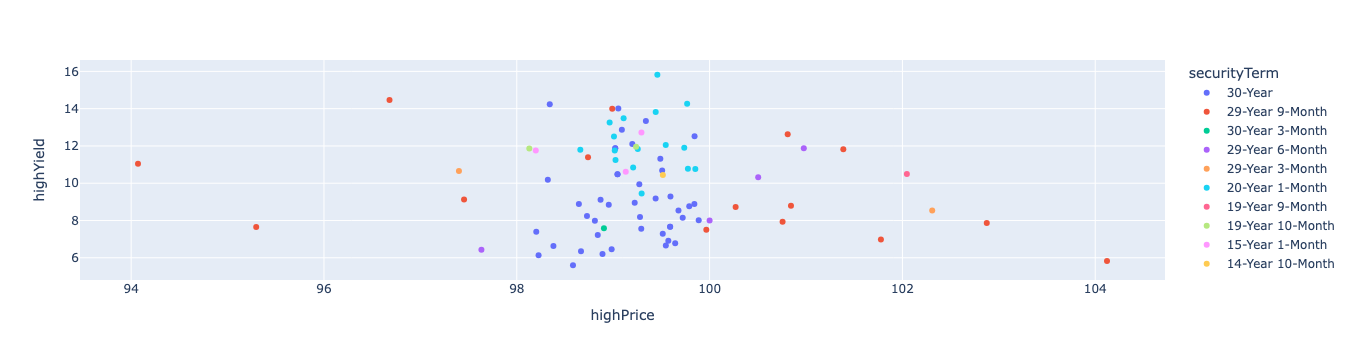

In [ ]:
df['year']=df['issueDate'].dt.year.astype(str)


px.scatter(
    data_frame=df[df['lowPrice']>0],
    x='highPrice',
    y='highYield',
    color='securityTerm'
)